# 1 Izbira metode in optimizacija hiperparametrov

In [13]:
import pandas as pd
import numpy as np

PODATKI = 'podatki.csv'
RANDOM_SEED = 420

In [14]:
data = pd.read_csv(PODATKI)
print('Število primerov: ', len(data))
features = data.columns[:-1]
data['y'].value_counts()

Število primerov:  1203


teamEdward    1025
teamJacob      178
Name: y, dtype: int64

Originalni podatki, iz katerih je pridobljen dataset `data`, vsebujejo največ 130 značilk in 2203 primerov. Očitno gre za binarno klasifikacijo.

In [15]:
# za lažje delo spremenim y 
data['y'] = data['y'].map(lambda x : True if x == 'teamEdward' else False)
data['y'].value_counts()

True     1025
False     178
Name: y, dtype: int64

## 1.1 Ročno

Ročno bom preizkusil drevesa, najbližje sosede in svm. Za radnom forest uporabljam impementacijo `LightGBM` za drevesa in `ray` za hyperoptimizacijo parametrov.

In [16]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test =  train_test_split(data[features], data['y'], test_size=1/4, random_state=RANDOM_SEED)


# save to parquet
X_test['y'] = y_test
X_test.to_parquet('parquet/test.pq')
X_test = X_test.drop(columns = ['y'])

In [17]:
from ray import tune 

def tune_classifier(config):
    model = LGBMClassifier(**config)
    cv_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)


    mean_roc_auc = np.mean(cv_results)
    
    tune.report(
        mean_roc_auc=mean_roc_auc,
        done=True,
    )

In [18]:
config = {
    "objective": "binary",
    "metric": "auc",
    "verbose": -1,
    "boosting_type": "gbdt",
    "num_leaves": tune.randint(5, 100),
    "n_estimators": tune.randint(50, 100),
    "min_child_samples": tune.choice([5, 10, 15, 25, 50,  100, 200]),
    "learning_rate": tune.loguniform(1e-2, 0.05),
}
analysis = tune.run(tune_classifier, resources_per_trial={"cpu": 5}, config=config, num_samples=200, verbose=1, raise_on_failed_trial=False)
results = analysis.dataframe()
results.head()

2023-03-30 10:33:48,506	INFO tune.py:762 -- Total run time: 25.24 seconds (24.73 seconds for the tuning loop).


,mean_roc_auc,done,time_this_iter_s,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,...,warmup_time,config/boosting_type,config/learning_rate,config/metric,config/min_child_samples,config/n_estimators,config/num_leaves,config/objective,config/verbose,logdir
0,0.927553,True,0.515913,NaN,NaN,1,888e5_00000,d0ba25196dea4cff962805bcc014b60f,2023-03-30_10-33-25,1680165205,...,0.002263,gbdt,0.044942,auc,5,93,61,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
1,0.928350,True,0.155181,NaN,NaN,1,888e5_00001,72869e707e394cbf97e969eed7e30b8b,2023-03-30_10-33-27,1680165207,...,0.004357,gbdt,0.043852,auc,100,63,65,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
2,0.928383,True,0.450943,NaN,NaN,1,888e5_00002,310e3c0482a44cdaaeef91ae390b9c65,2023-03-30_10-33-28,1680165208,...,0.004751,gbdt,0.011636,auc,15,83,57,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
3,0.928604,True,0.197156,NaN,NaN,1,888e5_00003,d0ba25196dea4cff962805bcc014b60f,2023-03-30_10-33-26,1680165206,...,0.002263,gbdt,0.013168,auc,15,69,83,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
4,0.931060,True,0.170033,NaN,NaN,1,888e5_00004,d0ba25196dea4cff962805bcc014b60f,2023-03-30_10-33-26,1680165206,...,0.002263,gbdt,0.025285,auc,25,75,89,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...


In [19]:
params = results.iloc[0]
params_dict = results.loc[params.name][[col for col in results.columns if col.startswith('config')]].to_dict()
params_dict = {k.replace('config/', ''): v for k, v in params_dict.items()}
# za shranjevanjevanje modela:
# import json
# json.dump(params_dict, open("best_params_trees.json", "w"), indent=2)

# loading:
# params_dict = json.load(open('best_params.json', 'r'))
params_dict

{'boosting_type': 'gbdt',
 'learning_rate': 0.044941644314025635,
 'metric': 'auc',
 'min_child_samples': 5,
 'n_estimators': 93,
 'num_leaves': 61,
 'objective': 'binary',
 'verbose': -1}

Ploščina pod ROC krivuljo je:  0.9178254313955436


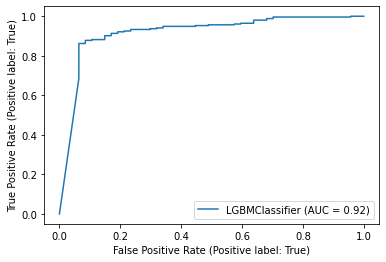

In [20]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

model = LGBMClassifier(**params_dict)
model.fit(X_train, y_train)

pred_proba = model.predict_proba(X_test)
performance = roc_auc_score(y_test, pred_proba[:,1])


print('Ploščina pod ROC krivuljo je: ', performance)


RocCurveDisplay.from_estimator(model, X_test, y_test)

## 1.2 Avtomatizirano
Preizkusili bomo gradient-boosting drevesa,  najbližje sosede in svm. Uporabili bomo kombinacijo `Hyperopt` za optimizacijo in `ray.tune` za vodenje in potek procesa. 


*TODO mogoče še:random forest*

In [21]:
from hyperopt import hp

# hack za svc 
def restack(params):
    ''' 
    Spremeni slovar za parametre za SVC, ki je oblike 
    'kernel_params' : { parametri p1 : P1, p2 : P2, ... },
     'q2: Q2 ... 

    v en slovar oblike 
    'p1' : P1
    p2 : P2, 
    ...
    q2 : Q2
    ...
    '''
    nested_dict = params.get('kernel_params')
    if nested_dict is None:
        return params
    for key, value in nested_dict.items():
        params[key] = value 
    params.pop('kernel_params')
    return params
    

# prostor možnih parametrov
param_space = {
    "algo": hp.choice('algo', [
        # lepa rešitev je, da hp za 'algo' izbere nek slovar, kjer je 
        # 'model' - (sklarn-type) model 
        # 'params' - parametri tega modela 
        # na tak način se znotraj kode za kriterijsko funckijo ognemo ločevanja na možne izbire! 
        {
            'name' : 'lgbm',
            'model' : LGBMClassifier,
            'params' : {
                "objective": "binary",
                "metric": "auc",
                "verbose": -1,
                "boosting_type": "gbdt",
                # loguniform - večje vrednosti so bolj narazen
                "num_leaves": hp.choice("num_leaves", [i**2 for i in range(3, 15)]),
                "n_estimators": hp.choice('n_estimators', [i**2 for i in range(3, 20)]),
                "min_child_samples": hp.choice('min_child_samples', [5, 10, 15, 25, 50,  100, 200, 500]),
                "learning_rate": hp.loguniform('learning_rate',1e-2, 0.05),
            }
        }, 
        {
            'name' : 'knn',
            'model' : KNeighborsClassifier,
            'params' : {
                'n_neighbors': hp.choice("n_neighbors", [1, 2, 3, 4, 5, 10, 15, 25]), 
                'n_jobs' : -1,
            }
        },
        {
            'name' : 'svc',
            'model' : SVC,
            'params' : {
                'C': hp.lognormal('C', 0, 1),
                'kernel_params': hp.choice('kernel_params', [
                    {
                        'kernel': 'linear'  # linearno
                    },
                    {
                        'kernel': 'rbf',  # radialno
                        'gamma': hp.lognormal('gamma', 0, 1)
                    },
                    {
                        'kernel': 'poly',  # polinomsko
                        'degree': hp.choice("degree", [1, 2])
                    }
                ]),
            }
        }

    ])
}

In [22]:
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter
from ray.tune import CLIReporter
from ray.air import RunConfig

NUM_SAMPLES = 250
SVC_RESAMPLE_FACTOR=0.1 # 120 primerov

# kriterijska funckija
def criterion_function(config, return_score=False):
    '''
    Kriterijska funckija.
   
    Input
    -----
    :param config: slovar izbranih parametrov z ključi 'name', 'model' in 'params' 
    
    '''
    name = config['algo']['name']
    params = config['algo']['params']
    # svc ima parametre, ki so odvisni od 'kernel' : *. --> hardcoded
    if name == 'svc':
        params = restack(params)
    # ustvari model z željenimi parametri
    model = config['algo']['model'](**params)
    
    
    # učna množica za model: 
    X = X_train
    y = y_train
    # SVC se uči prepočasi, zato mu dam manj podatkov
    if name == 'svc':
        data = X
        data['y'] = y 
        data = data.sample(frac=SVC_RESAMPLE_FACTOR)
        X = data.drop(columns=['y'])
        y = data['y']
    # prečno preverjanje
    cv_results = cross_val_score(model, X, y, scoring='roc_auc', cv=5)


    mean_roc_auc = np.mean(cv_results)
    
    tune.report(
        mean_roc_auc=mean_roc_auc,
        done=True,
    )
    # vrne za minimizacijo!
    # return 1 - mean_roc_auc

# maximiziramo ploščino mod krivuljo
algo = HyperOptSearch(space=param_space, metric="mean_roc_auc", mode="max")
algo = ConcurrencyLimiter(algo, max_concurrent=8)

# logging, progress
reporter = CLIReporter()

tune_config = tune.TuneConfig(
    metric = 'mean_roc_auc',
    mode = 'max',
    search_alg=algo,
    num_samples=NUM_SAMPLES
)

run_config =RunConfig(progress_reporter=reporter)

tuner = tune.Tuner(criterion_function, tune_config=tune_config, run_config=run_config)
results = tuner.fit()

== Status ==
Current time: 2023-03-30 10:33:53 (running for 00:00:02.20)
Memory usage on this node: 10.3/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 1/250 (1 RUNNING)




Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_roc_auc,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
criterion_function_43de04e6,2023-03-30_10-33-53,True,,f8a74f57ab3842b286410de516e96495,sgsnb-upri,1,0.684306,192.168.0.105,783557,0.0411024,0.0411024,0.0411024,1680165233,0,,1,43de04e6,0.00333214
criterion_function_bf07be94,2023-03-30_10-33-53,True,,f8a74f57ab3842b286410de516e96495,sgsnb-upri,1,0.885889,192.168.0.105,783557,0.0686457,0.0686457,0.0686457,1680165233,0,,1,bf07be94,0.00333214


2023-03-30 10:33:53,252	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:33:53,574	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:33:53,574	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:33:53,823	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:33:53,823	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:33:53,958	INFO tensorboardx.py:267 -- R

2023-03-30 10:34:00,242	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:00,397	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:34:01,219	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:34:01,273	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:01,370	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:34:01,428	INFO tensorboardx.py:2

== Status ==
Current time: 2023-03-30 10:34:10 (running for 00:00:19.09)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 30/250 (8 RUNNING, 22 TERMINATED)




2023-03-30 10:34:10,093	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:10,164	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:10,244	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:10,416	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:10,737	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:10,737	INFO tensorboardx.py:267 -- Removed the following hyperparame

2023-03-30 10:34:18,837	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:18,913	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:34:19,857	WARNING util.py:244 -- The `reset` operation took 0.936 s, which may be a performance bottleneck.
2023-03-30 10:34:19,864	WARNING util.py:244 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.
2023-03-30 10:34:19,932	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:20,077	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
20

2023-03-30 10:34:22,854	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:23,081	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:34:23,196	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:23,434	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:23,986	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:34:30,362	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:30,446	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:30,908	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:31,087	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:34:36,764	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:37,350	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:37,486	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:38,509	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:34:45,054	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:45,163	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:45,744	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:46,169	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:50,196	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


2023-03-30 10:34:51,899	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:52,474	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:56,799	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


2023-03-30 10:34:57,989	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:58,266	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:34:58,363	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:34:58,818	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:35:05,425	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:35:05,526	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:35:05,782	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:35:06,205	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:35:11,329	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:35:11,611	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:35:16,320	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:35:18,329	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:35:22 (running for 00:01:31.05)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 95/250 (7 RUNNING, 88 TERMINATED)




2023-03-30 10:35:22,416	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:35:27 (running for 00:01:36.96)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 97/250 (8 RUNNING, 89 TERMINATED)




2023-03-30 10:35:28,499	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:35:28,595	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:35:28,785	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:35:33,889	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:35:33 (running for 00:01:42.98)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 100/250 (7 RUNNING, 93 TERMINATED)




2023-03-30 10:35:34,226	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:35:40,556	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:35:41,456	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:35:47,197	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:35:47,913	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:35:53,544	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:35:54,386	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:35:59,318	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:35:59 (running for 00:02:08.82)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 108/250 (7 RUNNING, 101 TERMINATED)




2023-03-30 10:36:00,386	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:36:05,063	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:36:05 (running for 00:02:14.13)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 110/250 (7 RUNNING, 103 TERMINATED)


== Status ==
Current time: 2023-03-30 10:36:10 (running for 00:02:19.51)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:36:10,951	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:36:17 (running for 00:02:26.63)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 112/250 (8 RUNNING, 104 TERMINATED)




2023-03-30 10:36:18,415	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:36:23,036	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:36:23 (running for 00:02:32.12)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 113/250 (7 RUNNING, 106 TERMINATED)


== Status ==
Current time: 2023-03-30 10:36:28 (running for 00:02:37.23)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:36:28,481	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:36:33 (running for 00:02:42.68)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 115/250 (8 RUNNING, 107 TERMINATED)




2023-03-30 10:36:34,019	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:36:37,943	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:36:43,000	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:36:43 (running for 00:02:52.05)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 117/250 (7 RUNNING, 110 TERMINATED)




2023-03-30 10:36:47,564	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:36:52,080	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:36:52 (running for 00:03:01.13)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 119/250 (7 RUNNING, 112 TERMINATED)


== Status ==
Current time: 2023-03-30 10:36:57 (running for 00:03:06.45)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:36:58,061	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:37:03,289	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:37:08 (running for 00:03:17.44)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 122/250 (8 RUNNING, 114 TERMINATED)


== Status ==
Current time: 2023-03-30 10:37:13 (running for 00:03:22.46)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:39:44,046	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:39:49 (running for 00:05:58.31)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 123/250 (8 RUNNING, 115 TERMINATED)




2023-03-30 10:39:49,958	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:39:55 (running for 00:06:04.71)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 124/250 (8 RUNNING, 116 TERMINATED)




2023-03-30 10:39:56,448	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:40:01,286	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:40:01 (running for 00:06:10.37)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 125/250 (7 RUNNING, 118 TERMINATED)


== Status ==
Current time: 2023-03-30 10:40:07 (running for 00:06:16.44)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:40:07,937	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:40:13 (running for 00:06:22.22)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 127/250 (8 RUNNING, 119 TERMINATED)




2023-03-30 10:40:13,828	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:40:19,297	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:40:25 (running for 00:06:34.77)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 129/250 (8 RUNNING, 121 TERMINATED)




2023-03-30 10:40:26,342	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:40:31,349	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:40:31 (running for 00:06:40.40)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 130/250 (7 RUNNING, 123 TERMINATED)


== Status ==
Current time: 2023-03-30 10:40:37 (running for 00:06:46.22)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:40:37,934	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:40:44 (running for 00:06:53.57)
Memory usage on this node: 11.3/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 132/250 (8 RUNNING, 124 TERMINATED)




2023-03-30 10:40:44,942	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:40:50 (running for 00:06:59.78)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 133/250 (8 RUNNING, 125 TERMINATED)




2023-03-30 10:40:51,421	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:40:57 (running for 00:07:06.27)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 134/250 (8 RUNNING, 126 TERMINATED)




2023-03-30 10:40:57,654	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:41:02,066	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:41:02 (running for 00:07:11.15)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 135/250 (7 RUNNING, 128 TERMINATED)


== Status ==
Current time: 2023-03-30 10:41:08 (running for 00:07:17.48)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:41:09,172	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:41:14,509	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:41:21 (running for 00:07:30.27)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 138/250 (8 RUNNING, 130 TERMINATED)




2023-03-30 10:41:21,729	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:41:28 (running for 00:07:37.15)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 139/250 (8 RUNNING, 131 TERMINATED)




2023-03-30 10:41:29,062	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:41:34 (running for 00:07:43.22)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 140/250 (8 RUNNING, 132 TERMINATED)




2023-03-30 10:41:35,014	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:41:40 (running for 00:07:49.16)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 141/250 (8 RUNNING, 133 TERMINATED)


== Status ==
Current time: 2023-03-30 10:41:45 (running for 00:07:54.19)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:42:58,385	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:43:03 (running for 00:09:12.90)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 142/250 (8 RUNNING, 134 TERMINATED)




2023-03-30 10:43:04,735	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:43:09,183	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:43:09 (running for 00:09:18.23)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 143/250 (7 RUNNING, 136 TERMINATED)


== Status ==
Current time: 2023-03-30 10:43:14 (running for 00:09:23.70)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:43:15,257	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:43:20,987	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:43:26 (running for 00:09:35.59)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 146/250 (8 RUNNING, 138 TERMINATED)




2023-03-30 10:43:27,320	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:43:32 (running for 00:09:42.00)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 147/250 (8 RUNNING, 139 TERMINATED)




2023-03-30 10:43:33,459	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:43:38 (running for 00:09:47.61)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 148/250 (8 RUNNING, 140 TERMINATED)




2023-03-30 10:43:38,959	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:43:44,006	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:43:44 (running for 00:09:53.05)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 149/250 (7 RUNNING, 142 TERMINATED)


== Status ==
Current time: 2023-03-30 10:43:49 (running for 00:09:58.36)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:43:50,024	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:43:55 (running for 00:10:04.59)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 151/250 (8 RUNNING, 143 TERMINATED)




2023-03-30 10:43:56,078	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:44:01 (running for 00:10:10.74)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 152/250 (8 RUNNING, 144 TERMINATED)




2023-03-30 10:44:02,326	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:44:07 (running for 00:10:16.94)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 153/250 (8 RUNNING, 145 TERMINATED)




2023-03-30 10:44:08,628	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:44:13,403	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:44:13 (running for 00:10:22.49)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 154/250 (7 RUNNING, 147 TERMINATED)


== Status ==
Current time: 2023-03-30 10:44:19 (running for 00:10:28.06)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:44:19,328	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:44:24 (running for 00:10:33.62)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 156/250 (8 RUNNING, 148 TERMINATED)




2023-03-30 10:44:25,307	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:44:30 (running for 00:10:39.79)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 157/250 (8 RUNNING, 149 TERMINATED)




2023-03-30 10:44:31,453	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:44:36 (running for 00:10:45.89)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 158/250 (8 RUNNING, 150 TERMINATED)




2023-03-30 10:44:37,484	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:44:42,610	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:44:42 (running for 00:10:51.66)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 159/250 (7 RUNNING, 152 TERMINATED)


== Status ==
Current time: 2023-03-30 10:44:47 (running for 00:10:56.92)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:44:48,398	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:44:53,027	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:44:53 (running for 00:11:02.08)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 161/250 (7 RUNNING, 154 TERMINATED)


== Status ==
Current time: 2023-03-30 10:44:58 (running for 00:11:07.20)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:44:58,597	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:45:03,136	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:45:08 (running for 00:11:17.77)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 164/250 (8 RUNNING, 156 TERMINATED)




2023-03-30 10:45:09,321	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:45:09 (running for 00:11:18.41)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 164/250 (7 RUNNING, 157 TERMINATED)


== Status ==
Current time: 2023-03-30 10:45:14 (running for 00:11:23.75)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:45:15,530	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:45:20,599	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:45:20 (running for 00:11:29.70)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 166/250 (7 RUNNING, 159 TERMINATED)




2023-03-30 10:45:25,291	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:45:30 (running for 00:11:39.41)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 168/250 (8 RUNNING, 160 TERMINATED)




2023-03-30 10:45:30,666	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:45:36 (running for 00:11:45.12)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 169/250 (8 RUNNING, 161 TERMINATED)




2023-03-30 10:45:36,468	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:45:41,323	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:45:41 (running for 00:11:50.42)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 170/250 (7 RUNNING, 163 TERMINATED)


== Status ==
Current time: 2023-03-30 10:45:46 (running for 00:11:55.91)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:45:47,578	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:45:53 (running for 00:12:02.11)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 172/250 (8 RUNNING, 164 TERMINATED)




2023-03-30 10:45:53,792	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:45:58,751	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:45:58 (running for 00:12:07.80)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 173/250 (7 RUNNING, 166 TERMINATED)


== Status ==
Current time: 2023-03-30 10:46:03 (running for 00:12:12.93)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:49:51,380	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:49:56 (running for 00:16:05.85)
Memory usage on this node: 11.1/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 175/250 (8 RUNNING, 167 TERMINATED)




2023-03-30 10:49:57,879	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:00,323	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:50:02,698	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


2023-03-30 10:50:05,309	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:10,046	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:50:10 (running for 00:16:19.44)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 179/250 (7 RUNNING, 172 TERMINATED)




2023-03-30 10:50:10,839	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:14,786	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:50:16,598	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:50:19 (running for 00:16:28.26)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 182/250 (7 RUNNING, 175 TERMINATED)




2023-03-30 10:50:19,898	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:24,180	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


2023-03-30 10:50:25,515	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:50:25,692	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:26,554	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:27,975	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:50:32,026	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:50:34,344	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:34,666	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:34,878	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:50:35,378	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:35,580	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:40,546	INFO tensorboardx.py:267 -- Removed th

== Status ==
Current time: 2023-03-30 10:50:40 (running for 00:16:49.79)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 195/250 (7 RUNNING, 188 TERMINATED)




2023-03-30 10:50:41,258	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:41,439	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:41,804	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


2023-03-30 10:50:47,733	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:48,041	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:48,265	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:49,212	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:53,298	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


2023-03-30 10:50:55,060	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:55,598	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:50:56,135	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:00,493	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:51:02 (running for 00:17:11.20)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 207/250 (7 RUNNING, 200 TERMINATED)




2023-03-30 10:51:02,768	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:02,979	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:07,558	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


2023-03-30 10:51:09,063	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:09,408	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:51:09,621	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:10,407	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:15,132	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:51:16,329	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:17,040	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:51:23,259	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:23,713	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:51:29,115	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:51:29,754	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:51:36 (running for 00:17:45.29)
Memory usage on this node: 11.3/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 222/250 (8 RUNNING, 214 TERMINATED)




2023-03-30 10:51:43,302	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-03-30 10:51:43,485	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:44,176	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:51:51,322	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:51:51,857	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:51:57,840	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 10:51:58,576	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:52:04,658	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:52:05,193	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:52:09,235	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:52:10 (running for 00:18:19.47)
Memory usage on this node: 11.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 234/250 (7 RUNNING, 227 TERMINATED)




2023-03-30 10:52:11,162	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:52:16,305	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:52:16 (running for 00:18:25.36)
Memory usage on this node: 11.5/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 236/250 (7 RUNNING, 229 TERMINATED)




2023-03-30 10:52:16,958	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:52:22 (running for 00:18:31.50)
Memory usage on this node: 11.5/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 238/250 (8 RUNNING, 230 TERMINATED)




2023-03-30 10:52:23,142	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:52:28 (running for 00:18:37.41)
Memory usage on this node: 11.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 239/250 (8 RUNNING, 231 TERMINATED)




2023-03-30 10:52:29,269	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:52:34,248	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:52:34 (running for 00:18:43.36)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 240/250 (7 RUNNING, 233 TERMINATED)


== Status ==
Current time: 2023-03-30 10:52:39 (running for 00:18:48.72)
Memory usage on this node: 11.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:52:40,696	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:52:46 (running for 00:18:55.22)
Memory usage on this node: 11.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 242/250 (8 RUNNING, 234 TERMINATED)




2023-03-30 10:52:46,691	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:52:51,652	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:52:51 (running for 00:19:00.70)
Memory usage on this node: 11.3/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 243/250 (7 RUNNING, 236 TERMINATED)




2023-03-30 10:52:56,332	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:53:01 (running for 00:19:10.93)
Memory usage on this node: 11.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 245/250 (8 RUNNING, 237 TERMINATED)




2023-03-30 10:53:02,696	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:53:08 (running for 00:19:17.46)
Memory usage on this node: 11.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 246/250 (8 RUNNING, 238 TERMINATED)




2023-03-30 10:53:09,060	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-03-30 10:53:14,079	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}


== Status ==
Current time: 2023-03-30 10:53:14 (running for 00:19:23.13)
Memory usage on this node: 11.3/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 247/250 (7 RUNNING, 240 TERMINATED)


== Status ==
Current time: 2023-03-30 10:53:19 (running for 00:19:28.56)
Memory usage on this node: 11.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:53:19,975	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


2023-03-30 10:53:25,305	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:53:30 (running for 00:19:39.88)
Memory usage on this node: 11.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 250/250 (8 RUNNING, 242 TERMINATED)




2023-03-30 10:53:31,542	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}


== Status ==
Current time: 2023-03-30 10:53:36 (running for 00:19:45.60)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 250/250 (7 RUNNING, 243 TERMINATED)


== Status ==
Current time: 2023-03-30 10:53:41 (running for 00:19:50.68)
Memory usage on this node: 11.2/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:54:37,303	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:54:42 (running for 00:20:51.42)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 250/250 (6 RUNNING, 244 TERMINATED)


== Status ==
Current time: 2023-03-30 10:54:47 (running for 00:20:56.45)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:55:15,537	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:55:20 (running for 00:21:29.60)
Memory usage on this node: 11.0/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 250/250 (5 RUNNING, 245 TERMINATED)


== Status ==
Current time: 2023-03-30 10:55:25 (running for 00:21:34.67)
Memory usage on this node: 10.9/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:58:21,174	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:58:26 (running for 00:24:35.23)
Memory usage on this node: 10.8/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 250/250 (4 RUNNING, 246 TERMINATED)


== Status ==
Current time: 2023-03-30 10:58:31 (running for 00:24:40.30)
Memory usage on this node: 10.8/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 10:58:52,089	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 10:58:57 (running for 00:25:06.14)
Memory usage on this node: 10.7/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 250/250 (3 RUNNING, 247 TERMINATED)


== Status ==
Current time: 2023-03-30 10:59:02 (running for 00:25:11.19)
Memory usage on this node: 10.7/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 11:00:25,759	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 11:00:28,032	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}


== Status ==
Current time: 2023-03-30 11:00:28 (running for 00:26:37.07)
Memory usage on this node: 10.6/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 250/250 (1 RUNNING, 249 TERMINATED)


== Status ==
Current time: 2023-03-30 11:00:33 (running for 00:26:42.12)
Memory usage on this node: 10.6/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and para

2023-03-30 11:01:17,841	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.svm._classes.SVC'>}
2023-03-30 11:01:18,051	INFO tune.py:762 -- Total run time: 1647.09 seconds (1646.87 seconds for the tuning loop).


== Status ==
Current time: 2023-03-30 11:01:17 (running for 00:27:26.89)
Memory usage on this node: 10.4/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/14.25 GiB heap, 0.0/7.13 GiB objects
Current best trial: 91830ad6 with mean_roc_auc=1.0 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-03-30_10-33-50
Number of trials: 250/250 (250 TERMINATED)
+-----------------------------+------------+----------------------+----------------------+-------------+-----------------+------------------------+------------------------+------------------------+------------------------+------------------------+----------------------+------------------------+------------

Najboljši model je :  lgbm  s parametri  {'boosting_type': 'gbdt', 'learning_rate': 1.0391968025342897, 'metric': 'auc', 'min_child_samples': 25, 'n_estimators': 25, 'num_leaves': 81, 'objective': 'binary', 'verbose': -1}
Ploščina pod ROC krivuljo je:  0.906768302898308


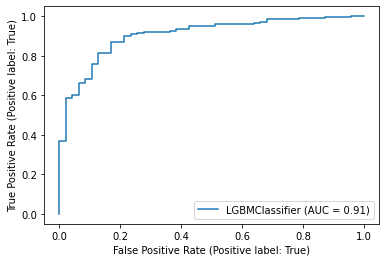

In [23]:
best_model_name = results.get_best_result().config['algo']['name']
best_params = results.get_best_result().config['algo']['params']
best_model = results.get_best_result().config['algo']['model']
if best_model_name == 'svc':
    best_params = restack(best_params)

print("Najboljši model je : ", best_model_name, " s parametri ", best_params)
# create a model with best params 
model = best_model(**best_params)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_test)
performance = roc_auc_score(y_test, pred_proba[:,1])

print('Ploščina pod ROC krivuljo je: ', performance)
RocCurveDisplay.from_estimator(model, X_test, y_test)

In [25]:
from hyperopt import fmin, Trials, tpe, space_eval
trials = Trials()

# kriterijska funckija
def criterion_function_hyperopt(config, return_score=False):
    '''
    Kriterijska funckija.
   
    Input
    -----
    :param config: slovar izbranih parametrov z ključi 'name', 'model' in 'params' 
    
    '''
    name = config['algo']['name']
    params = config['algo']['params']
    # svc ima parametre, ki so odvisni od 'kernel' : *. --> hardcoded
    if name == 'svc':
        params = restack(params)
    # ustvari model z željenimi parametri
    model = config['algo']['model'](**params)
    
    
    # učna množica za model: 
    X = X_train
    y = y_train
    # SVC se uči prepočasi, zato mu dam manj podatkov
    if name == 'svc':
        data = X
        data['y'] = y 
        data = data.sample(frac=SVC_RESAMPLE_FACTOR)
        X = data.drop(columns=['y'])
        y = data['y']
    # prečno preverjanje
    cv_results = cross_val_score(model, X, y, scoring='roc_auc', cv=5)


    mean_roc_auc = np.mean(cv_results)
    
    # vrne za minimizacijo!
    return 1 - mean_roc_auc

best = fmin(fn=criterion_function_hyperopt,
            space=param_space,
            algo=tpe.suggest,
            max_evals=NUM_SAMPLES,
            trials=trials)
best = space_eval(param_space, best)
best_value = criterion_function(best)
best

 37%|███▋      | 93/250 [27:11<24:03,  9.19s/trial, best loss: 0.0]                  